<a href="https://colab.research.google.com/github/anasCSD/Glaucoma-Classification/blob/main/EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print("Pytorch version:", torch.__version__)

Pytorch version: 2.9.0+cu126


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
%pip install ipython-autotime
%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.2 MB/s eta 0:00:00
time: 233 µs (started: 2025-11-25 16:04:32 +00:00)


In [ ]:
!pip install torchinfo

time: 4.43 s (started: 2025-11-25 16:04:42 +00:00)


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import os
import random
import shutil
import PIL as pil
import cv2
import matplotlib as mpl
import tqdm
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

time: 7.72 s (started: 2025-11-25 16:05:01 +00:00)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 30.4 s (started: 2025-11-25 16:05:19 +00:00)


In [ ]:
base_url = '/content/drive/MyDrive/Research'

batch_size = 4
img_height = 224
img_width = 224

class_names = ['glaucoma', 'normal']

time: 730 µs (started: 2025-11-25 16:06:03 +00:00)


In [ ]:
def model_summary(model:torch.nn.Module,
                  input_size:tuple):
  return summary(model=model,
                input_size=input_size,
                col_names=["input_size", "output_size", "num_params", "trainable"],
                col_width=20,
                row_settings=['var_names'])

time: 546 µs (started: 2025-11-25 16:06:16 +00:00)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor()
])

dataset_url = '/content/drive/MyDrive/Research/Glaucoma_Splitted'

train_path = f'{dataset_url}/train'
valid_path = f'{dataset_url}/val'
test_path = f'{dataset_url}/test'

train_ds = datasets.ImageFolder(root=train_path, transform=transform)
valid_ds = datasets.ImageFolder(root=valid_path, transform=transform)
test_ds = datasets.ImageFolder(root=test_path, transform=transform)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, num_workers=0,
                                          shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, num_workers=0,
                                          shuffle=False)

test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, num_workers=0,
                                         shuffle=False)

time: 6.93 s (started: 2025-11-25 16:06:33 +00:00)


In [ ]:
num_classes = 2


model = torchvision.models.efficientnet_b0(weights="DEFAULT")


for param in model.parameters():
    param.requires_grad = False

# Get input features of EfficientNet-B0 classifier
num_features = model.classifier[1].in_features      #  1280


model.classifier = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),

    nn.Linear(1024, 512),
    nn.ReLU(),

    nn.Linear(512, num_classes)
)


model = model.to(device)

# Model summary
summary(
    model,
    input_size=(4, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    row_settings=["var_names"]
)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 134MB/s] 


Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [4, 3, 224, 224]          [4, 2]                    --                        Partial
├─Sequential (features)                                      [4, 3, 224, 224]          [4, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation (0)                              [4, 3, 224, 224]          [4, 32, 112, 112]         --                        False
│    │    └─Conv2d (0)                                       [4, 3, 224, 224]          [4, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d (1)                                  [4, 32, 112, 112]         [4, 32, 112, 112]         (64)                      False
│    │    └─SiLU (2)                                         [4, 32, 112, 112]         [4, 32, 112, 112]         --         

time: 1.96 s (started: 2025-11-25 16:09:54 +00:00)


In [ ]:
params_to_train = model.classifier.parameters()

model = model.to(device)

learning_rate = 0.00001
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_train, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')



time: 5.79 ms (started: 2025-11-25 16:10:59 +00:00)


In [ ]:
filepath = f'{base_url}/Results/EfficientNetB0/model.pth'
print(os.path.exists(filepath))

False
time: 110 ms (started: 2025-11-25 16:11:38 +00:00)


In [ ]:
def evaluate(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / len(data_loader)
    accuracy = correct / total

    return loss, accuracy

time: 3.54 ms (started: 2025-11-25 16:12:01 +00:00)


In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):

    # History lists to store curves
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        # Validation check
        val_loss, val_accuracy = evaluate(model, val_loader, criterion)

        # Store in history
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            torch.save(model.state_dict(), filepath)
            print(f"Model weights saved to {filepath}")
            best_val_loss = val_loss

    # Return history for plotting
    return train_losses, val_losses, train_accuracies, val_accuracies


time: 2.23 ms (started: 2025-11-25 16:12:20 +00:00)


In [ ]:
train_losses, val_losses, train_acc, val_acc = train(
    model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs
)


Epoch 1/50, Train Loss: 0.5457, Train Accuracy: 0.7801, Val Loss: 0.5296, Val Accuracy: 0.7775
Model weights saved to /content/drive/MyDrive/Research/Results/EfficientNetB0/model.pth
Epoch 2/50, Train Loss: 0.5091, Train Accuracy: 0.7801, Val Loss: 0.5150, Val Accuracy: 0.7775
Model weights saved to /content/drive/MyDrive/Research/Results/EfficientNetB0/model.pth
Epoch 3/50, Train Loss: 0.5034, Train Accuracy: 0.7801, Val Loss: 0.5127, Val Accuracy: 0.7775
Model weights saved to /content/drive/MyDrive/Research/Results/EfficientNetB0/model.pth
Epoch 4/50, Train Loss: 0.4978, Train Accuracy: 0.7801, Val Loss: 0.4992, Val Accuracy: 0.7775
Model weights saved to /content/drive/MyDrive/Research/Results/EfficientNetB0/model.pth
Epoch 5/50, Train Loss: 0.4833, Train Accuracy: 0.7801, Val Loss: 0.4884, Val Accuracy: 0.7775
Model weights saved to /content/drive/MyDrive/Research/Results/EfficientNetB0/model.pth
Epoch 6/50, Train Loss: 0.4815, Train Accuracy: 0.7801, Val Loss: 0.4867, Val Accurac

In [ ]:
def plot_loss_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

time: 982 µs (started: 2025-11-25 19:01:58 +00:00)


In [ ]:
def plot_accuracy_curve(train_acc, val_acc):
    plt.figure(figsize=(10, 6))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


time: 670 µs (started: 2025-11-25 19:04:33 +00:00)


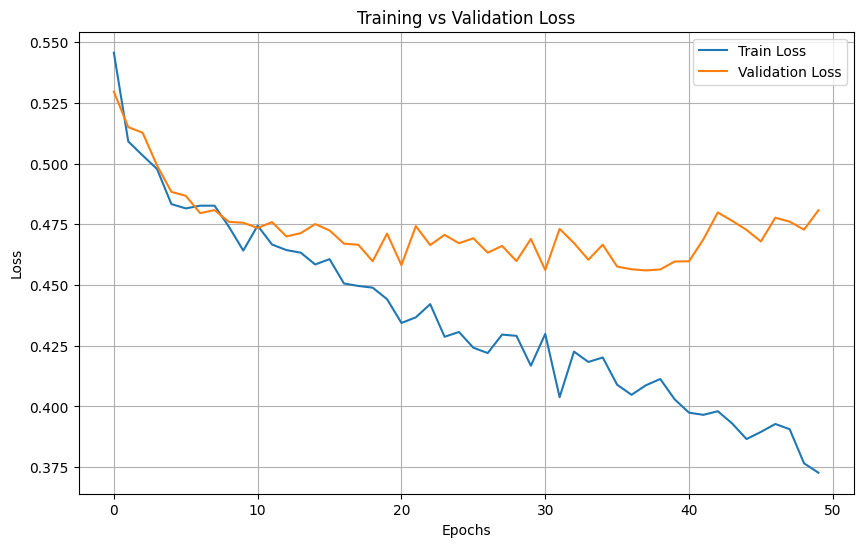

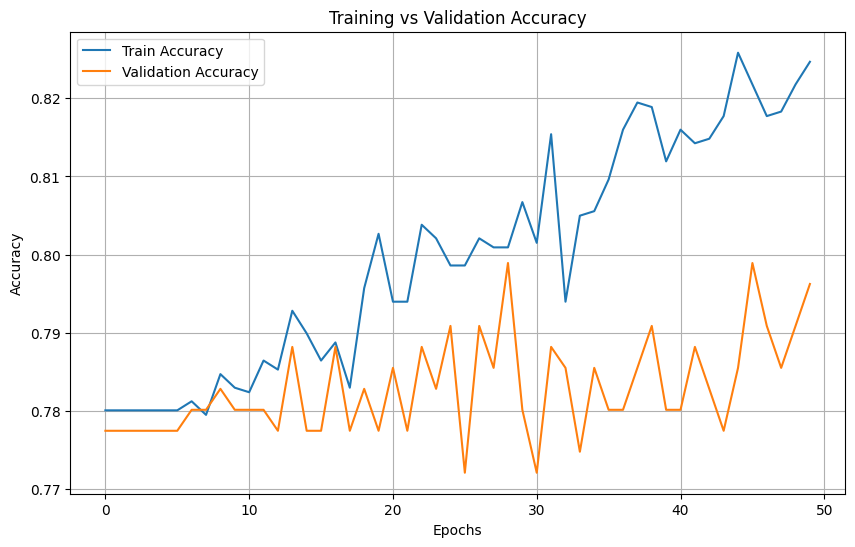

time: 352 ms (started: 2025-11-25 19:04:48 +00:00)


In [ ]:
plot_loss_curve(train_losses, val_losses)
plot_accuracy_curve(train_acc, val_acc)

In [ ]:
model.load_state_dict(torch.load(filepath))
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

time: 137 ms (started: 2025-11-25 19:05:11 +00:00)


In [ ]:
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.4721, Test Accuracy: 0.7676
time: 2min 25s (started: 2025-11-25 19:05:34 +00:00)


In [ ]:
train_loss, train_accuracy = evaluate(model, train_loader, criterion)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

Train Loss: 0.3578, Train Accuracy: 0.8356
time: 2min 23s (started: 2025-11-25 19:08:13 +00:00)


In [ ]:
val_loss, val_accuracy = evaluate(model, valid_loader, criterion)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Validation Loss: 0.4560, Validation Accuracy: 0.7855
time: 31.7 s (started: 2025-11-25 19:10:45 +00:00)


In [ ]:
def plot_confusion_matrix(model, dataloader, class_names, title="Confusion Matrix"):
    model.eval()
    all_actual = []
    all_predicted = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_actual.extend(labels.cpu().numpy())
            all_predicted.extend(preds.cpu().numpy())

    all_actual = np.array(all_actual)
    all_predicted = np.array(all_predicted)

    cm = confusion_matrix(all_actual, all_predicted)
    print(f"\n{title}:\n", cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

    return cm

time: 1.7 ms (started: 2025-11-25 19:11:49 +00:00)



Training Confusion Matrix:
 [[ 124  256]
 [  28 1320]]


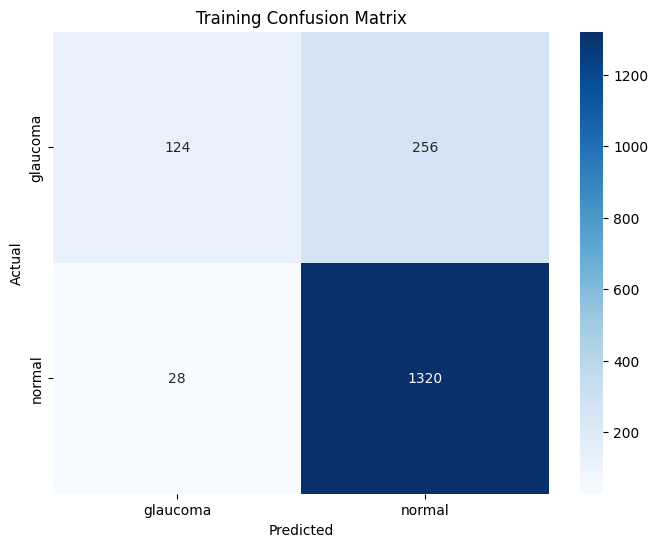

array([[ 124,  256],
       [  28, 1320]])

time: 2min 23s (started: 2025-11-25 19:12:06 +00:00)


In [ ]:
plot_confusion_matrix(model, train_loader, class_names, title="Training Confusion Matrix")


Validation Confusion Matrix:
 [[ 18  65]
 [ 15 275]]


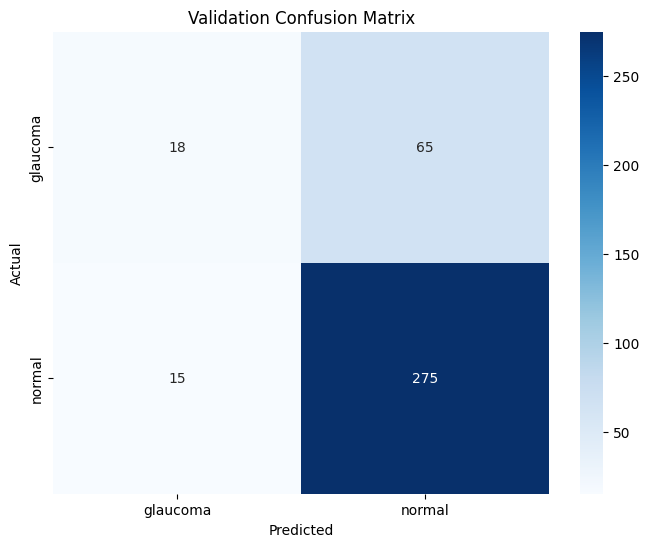

array([[ 18,  65],
       [ 15, 275]])

time: 32.2 s (started: 2025-11-25 19:15:12 +00:00)


In [ ]:
plot_confusion_matrix(model, valid_loader, class_names, title="Validation Confusion Matrix")


Test Confusion Matrix:
 [[ 12  69]
 [ 17 272]]


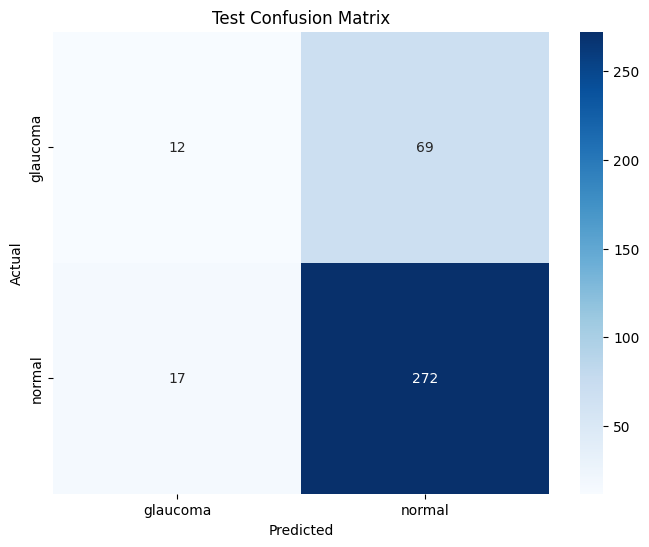

array([[ 12,  69],
       [ 17, 272]])

time: 37.2 s (started: 2025-11-25 19:16:32 +00:00)


In [ ]:
plot_confusion_matrix(model, test_loader, class_names, title="Test Confusion Matrix")

In [ ]:
def plot_roc_curve(model, test_loader, class_names):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            probs = torch.softmax(outputs, dim=1)  # convert logits → probabilities

            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())   # shape (batch,2)

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # ---- Manual 2-column binarize ----
    y_true_bin = np.zeros((len(y_true), len(class_names)))
    for idx, lab in enumerate(y_true):
        y_true_bin[idx, lab] = 1
    # ----------------------------------

    plt.figure(figsize=(10, 8))

    for i, name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)

        print(f"Class {name} ROC AUC: {roc_auc:.3f}")
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (ResNet101)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

time: 1.45 ms (started: 2025-11-25 19:17:35 +00:00)


Class glaucoma ROC AUC: 0.717
Class normal ROC AUC: 0.717


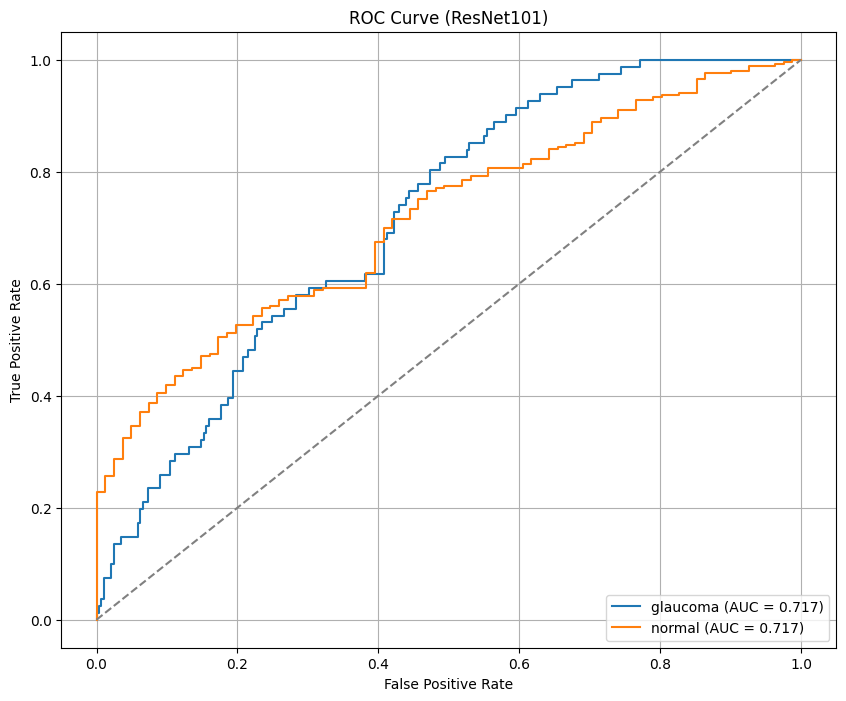

time: 32.2 s (started: 2025-11-25 19:17:52 +00:00)


In [ ]:
plot_roc_curve(model, test_loader, class_names)

Class glaucoma ROC AUC: 0.737
Class normal ROC AUC: 0.737


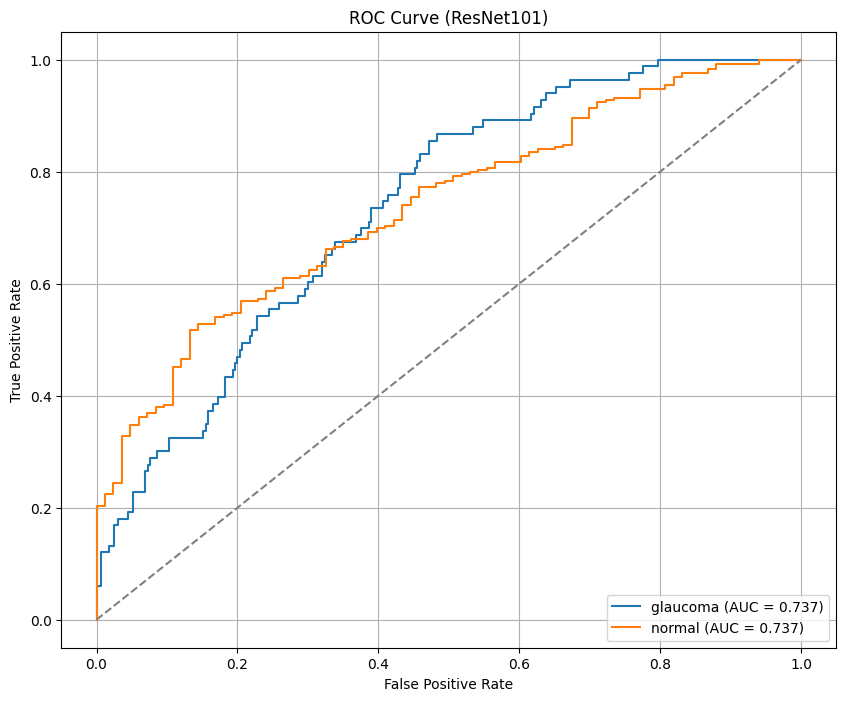

time: 33.8 s (started: 2025-11-25 19:18:46 +00:00)


In [ ]:
plot_roc_curve(model, valid_loader, class_names)

Class glaucoma ROC AUC: 0.882
Class normal ROC AUC: 0.882


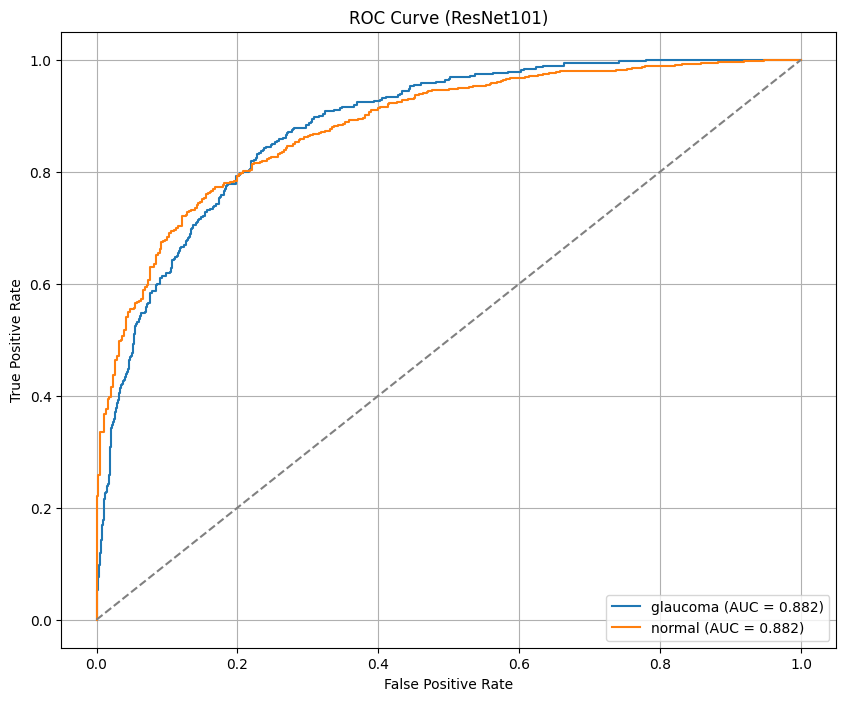

time: 2min 26s (started: 2025-11-25 19:19:28 +00:00)


In [ ]:
plot_roc_curve(model, train_loader, class_names)